In [1]:
import election_analysis as ea
import pickle
import pandas as pd
import geopandas as gp
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

#Packages from Scikit-learn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVR
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, StandardScaler, MinMaxScaler

import hashlib

In [41]:
#Simplified loading of data, directly from ACS csv files instead of reading Excel files from the Fed
acres_to_m2 = 4047.
def loadACS_CSV(filename):
    data = pd.read_csv(filename, encoding='latin1', low_memory=False,header=1, dtype={'Id2':'str'})
    data.index = data['Id2']
    data.index.name = 'FIPS'
    data = data.drop('Id',axis=1)
    data = data.rename({'Geography':'County Name'}, axis =1 )
    return data

def add_0(myStr):
    """
    Function to change a FIPS code integer into a standardized string with length 5
    """
    if int(len(str(int(myStr)))<5):
        return '0'+str(myStr)
    else:
        return str(myStr)
    
def divideBy100(val):
    return val/100.0
def squareVal(val):
    return val**2
def sqrtVal(val):
    return np.sqrt(val)

demographicsFilename = 'data_spreadsheets/ACS_16_5YR_Demographics/ACS_16_5YR_DP05_with_ann.csv'
economicsFilename = 'data_spreadsheets/ACS_16_5YR_Economic_Indicators/ACS_16_5YR_DP03_with_ann.csv'
socialFilename = 'data_spreadsheets/ACS_16_5YR_Social_Characteristics/ACS_16_5YR_DP02_with_ann.csv'

#Load Census data from CSV files
demographics = loadACS_CSV(demographicsFilename)
economics = loadACS_CSV(economicsFilename)
social = loadACS_CSV(socialFilename)

#Religious data from http://usreligioncensus.org/
#already did a pivot table on this data
religion = pd.read_csv('data_spreadsheets/religion.csv')
religion.index = religion['FIPSMERG'].apply(add_0).values

#Drug Poisoning data
def range_to_min(myStr):
    if '>' in str(myStr):
        return float(str(myStr).split('>')[1])
    else:
        return float(str(myStr).split('-')[0])

drugpoisoning = pd.read_csv('data_spreadsheets/drug_poisoning.csv').pivot(index='FIPS',columns='Year',values='Estimated Age-adjusted Death Rate, 16 Categories (in ranges)')
for column in drugpoisoning.columns:
    drugpoisoning[column] = pd.DataFrame(drugpoisoning[column].apply(range_to_min))
newDrugPoisoningColumns = []
for entry in drugpoisoning.columns:
    newDrugPoisoningColumns.append('Drug Poisoning, ' + str(entry))
drugpoisoning.columns = newDrugPoisoningColumns

drugpoisoning['FIPS_integers'] = drugpoisoning.index.values
drugpoisoning.index = drugpoisoning['FIPS_integers'].apply(add_0).values


#Climate change data
climatechange = pd.read_csv('data_spreadsheets/YCOM_2016_Data.01.csv')
climatechange = climatechange[climatechange['GeoType']=='County']
climatechange.index = climatechange['GEOID'].apply(add_0).values

#Agriculture data
def remove_comma(myStr):
    return float(myStr.replace(',',''))

def aggregateFIPS(row):
    countyFIPS = str(int(row['County ANSI']))
    stateFIPS = str(int(row['State ANSI']))
    while len(countyFIPS)<3:
        countyFIPS = '0'+countyFIPS
    while len(stateFIPS)<2:
        stateFIPS = '0'+stateFIPS
    return str(str(stateFIPS)+str(countyFIPS))

def load_agriculture(filename):
    crop = pd.read_csv(filename)
    crop.drop(['Week Ending', 'Watershed', 'CV (%)', 'Region', 'Zip Code'],axis=1, inplace=True)
    crop.dropna(inplace=True)
    crop['Value'] = crop['Value'].apply(remove_comma).values
    crop['FIPS'] = crop.apply(aggregateFIPS, axis=1)
    crop.index = crop['FIPS']
    return crop

soybeansFilename = 'data_spreadsheets/soybeans_planted_2016.csv'
soybeans = load_agriculture(soybeansFilename)
soybeans.rename({'Value':'Soybeans'}, inplace=True,axis=1)
cornFilename = 'data_spreadsheets/corn_planted_2016.csv'
corn = load_agriculture(cornFilename)
corn.rename({'Value':'Corn'}, inplace=True, axis=1)
cottonFilename = 'data_spreadsheets/cotton_planted_2016.csv'
cotton = load_agriculture(cottonFilename)
cotton.rename({'Value':'Cotton'}, inplace=True, axis=1)
winterwheatFilename = 'data_spreadsheets/winter_wheat_planted_2016.csv'
winterwheat = load_agriculture(winterwheatFilename)
winterwheat.rename({'Value':'WinterWheat'}, inplace=True, axis=1)
crops = pd.concat([soybeans['Soybeans'], corn['Corn'], cotton['Cotton'], winterwheat['WinterWheat']], axis=1, sort=True)
crops.fillna(0.0, inplace=True)

#Voting data
election_results = pd.read_excel('data_spreadsheets/US_County_Level_Presidential_Results_08-16.xlsx', 'Sheet 1', header=1, usecols=list(range(0,100)), skiprows=range(2,31))
election_results.index = election_results['combined_fips'].apply(add_0).values

#Get county shape information from shapefile
countyShapes = gp.read_file('cb_2015_us_county_5m/cb_2015_us_county_5m.shp')
countyShapes = countyShapes.set_index('GEOID')
countyShapes.index.name='FIPS'
countyShapes = countyShapes.sort_index()

#Merge all the data into a master GeoDataFrame, called 'usa'
ACS_data = demographics.merge(economics, left_index=True, right_index=True).merge(social, left_index=True, right_index=True)
other_data = pd.concat([crops, climatechange, drugpoisoning, religion, election_results],axis=1, sort=True)
data = pd.concat([ACS_data, other_data], axis=1, sort=True)
usa = countyShapes.merge(data, left_index=True, right_index=True)
usa['Soybeans'] = usa['Soybeans']*acres_to_m2/usa['ALAND']
usa['Corn'] = usa['Corn']*acres_to_m2/usa['ALAND']
usa['Cotton'] = usa['Cotton']*acres_to_m2/usa['ALAND']
usa['WinterWheat'] = usa['WinterWheat']*acres_to_m2/usa['ALAND']
usa.fillna(0.0, inplace=True)

In [94]:
def countyPlot(df, column,cmap='inferno',vmin=None,vmax=None,cLabel=None,extraTitle=None,saveFigure=None):
    """
    Takes a GeoPandas DataFrame df, and plots 'column' in a nice way
    """
    plotDF = gp.GeoDataFrame(df[column],geometry=df['geometry'])
    if not plotDF.crs:
        plotDF.crs={'init': 'epsg:4269'}
    lambertStringMainland = '+proj=lcc +lat_1=20 +lat_2=60 +lat_0=39 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs'
    lambertStringAlaska = '+proj=lcc +lat_1=20 +lat_2=60 +lat_0=40.5 +lon_0=-156 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs'
    lambertStringHawaii = '+proj=lcc +lat_1=20 +lat_2=60 +lat_0=20.5 +lon_0=-157 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs'

    fig = plt.figure(figsize=[20,10])
    
    #If color limits aren't explicitly set, they get set to the min/max of the data
    if not vmin and not vmax:
        vmin = np.min(list(map(float,(plotDF[column].values.tolist()))))
        vmax = np.max(list(map(float,(plotDF[column].values.tolist()))))
        print('set vmin!')
    #Mainland
    ax = plt.axes([0.0,0.0,1.0,1.0], projection=ccrs.LambertConformal(), frameon=False)
    ax.set_extent([-125.0, -74., 21.,52.])
    plotDF.to_crs(lambertStringMainland).plot(color='grey',ax=ax)
    plotDF.dropna().to_crs(lambertStringMainland).plot(column=column, cmap=cmap,ax=ax,vmin=vmin, vmax=vmax)

    #Alaska
    ax2 = plt.axes([0.0, 0.0, 0.43, 0.43],projection=ccrs.LambertConformal(central_latitude = 40.5, central_longitude = -156.), frameon=False)
    ax2.set_extent([180.0,-132., 45.,72])
    plotDF.to_crs(lambertStringAlaska).plot(color='grey',ax=ax2)
    plotDF.dropna().to_crs(lambertStringAlaska).plot(column=column, cmap=cmap,ax=ax2,vmin=vmin, vmax=vmax)

    #Hawaii
    ax3 = plt.axes([0.25, 0.0, 0.3, 0.2],projection=ccrs.LambertConformal(central_longitude=-157.0, central_latitude=20.5), frameon=False)
    ax3.set_extent([-162.0,-154., 18.,23.])
    plotDF.to_crs(lambertStringHawaii).plot(color='grey',ax=ax3)
    plotDF.dropna().to_crs(lambertStringHawaii).plot(column=column, cmap=cmap,ax=ax3,vmin=vmin, vmax=vmax)
    
    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)
    ax2.background_patch.set_visible(False)
    ax2.outline_patch.set_visible(False)
    ax3.background_patch.set_visible(False)
    ax3.outline_patch.set_visible(False)
    if extraTitle:
        plt.suptitle(extraTitle, x=0.8, y=0.35,color='black',size=20)
    if cLabel:
        axc = plt.axes([0.25, 0.92, 0.5, 0.015], frameon=False)
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        numTicks = 9
        cbarStep=float((vmax-vmin)/(numTicks-1.0))
        cb = mpl.colorbar.ColorbarBase(axc, ticks=np.linspace(vmin, vmax, numTicks),cmap=cmap,norm=norm,orientation='horizontal')
        cb.set_ticklabels(['{:.0f}'.format(int(x)) for x in np.arange(1.*vmin, 1.*(vmax+cbarStep), cbarStep)])
        cb.ax.xaxis.set_ticks_position('top')
        cb.set_label(cLabel, fontdict = {'horizontalalignment' : 'center', 'fontsize':14})
    if saveFigure:
        plt.savefig(saveFigure, bbox_inches='tight')

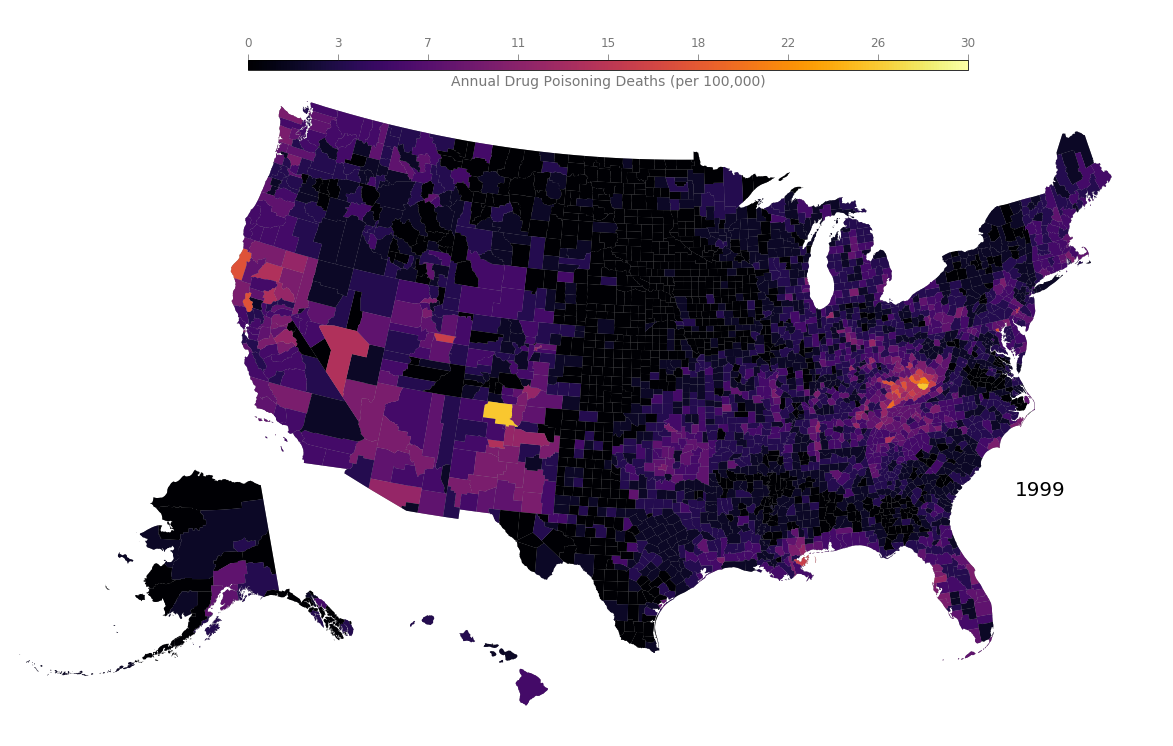

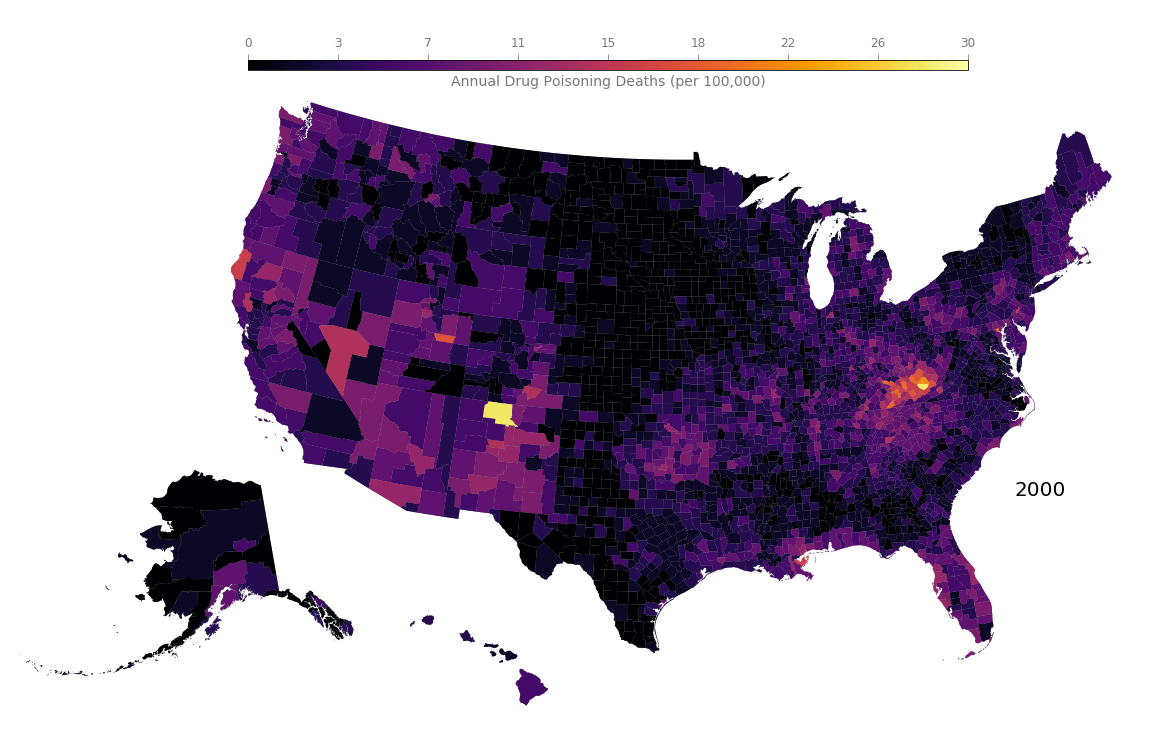

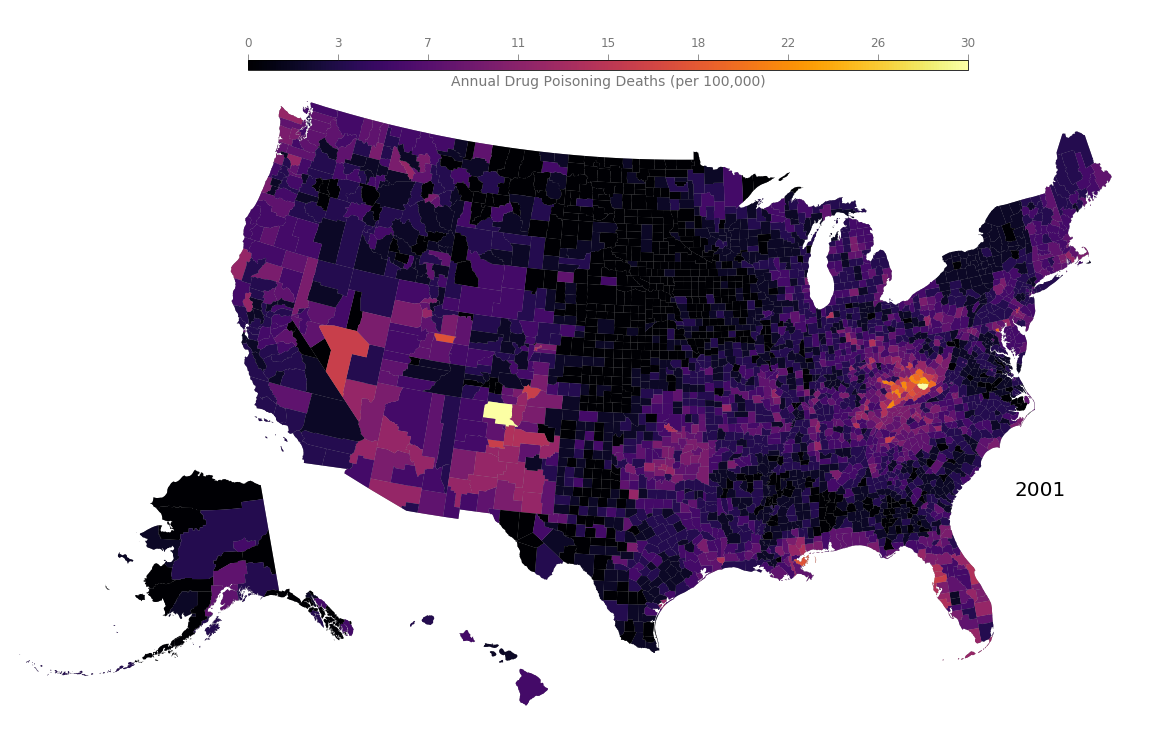

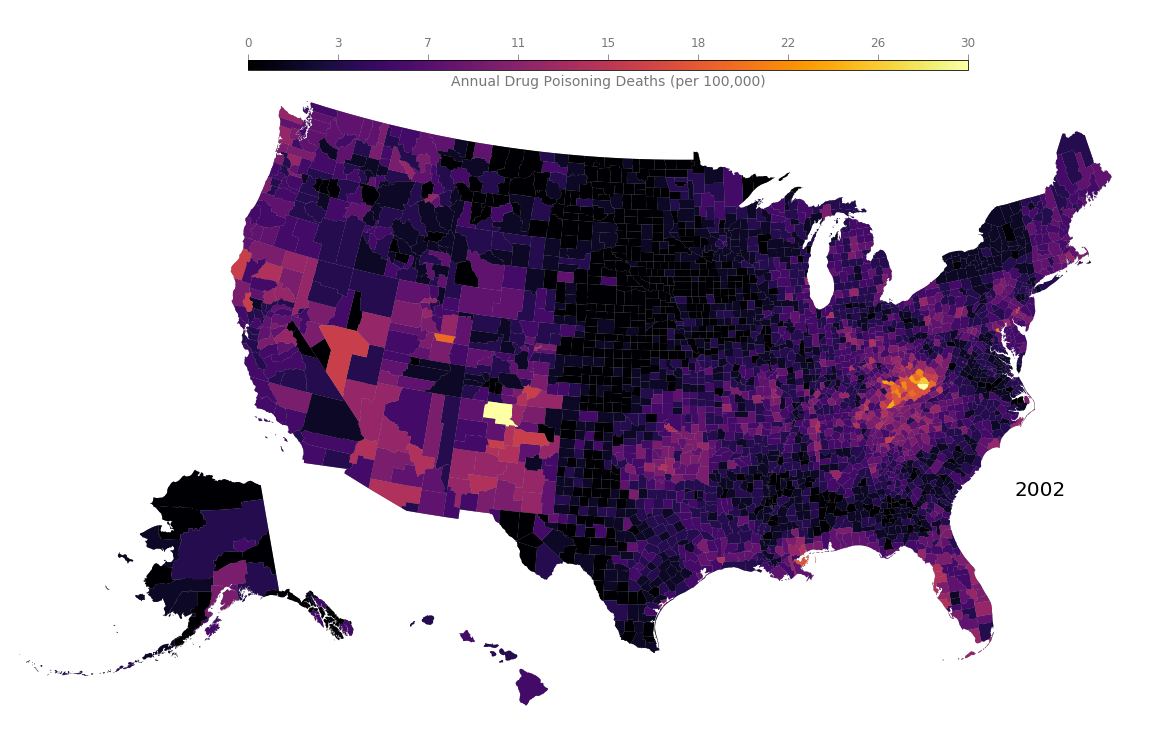

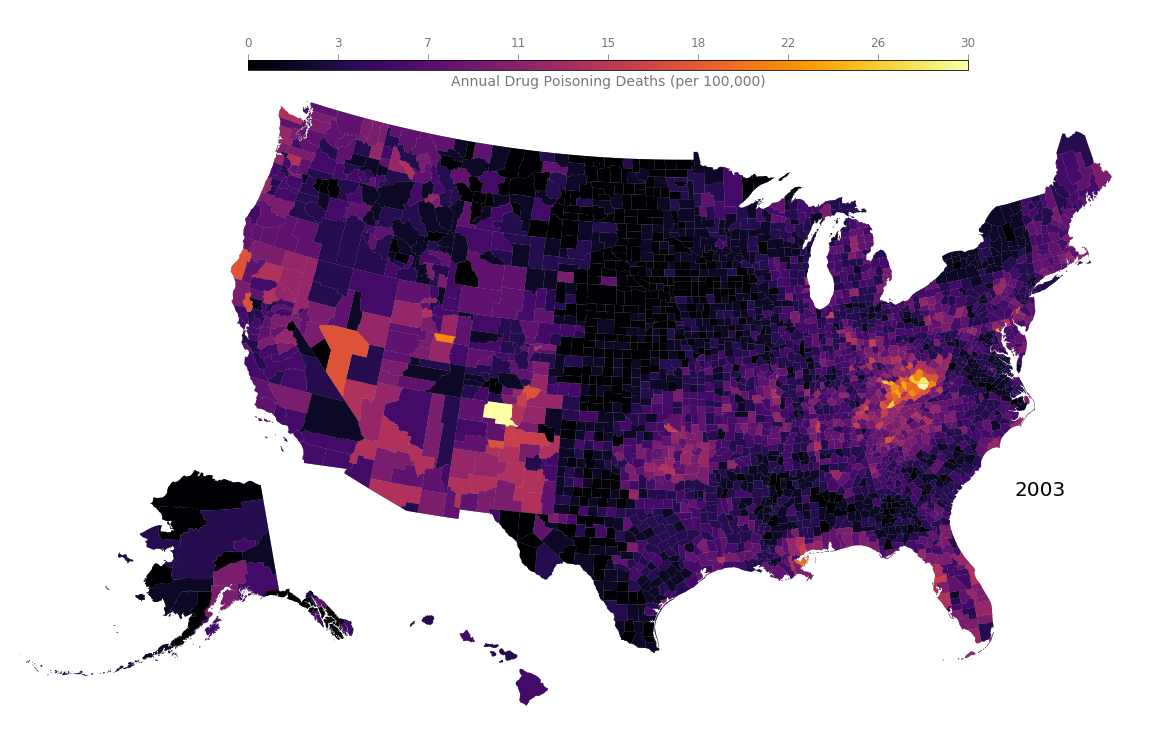

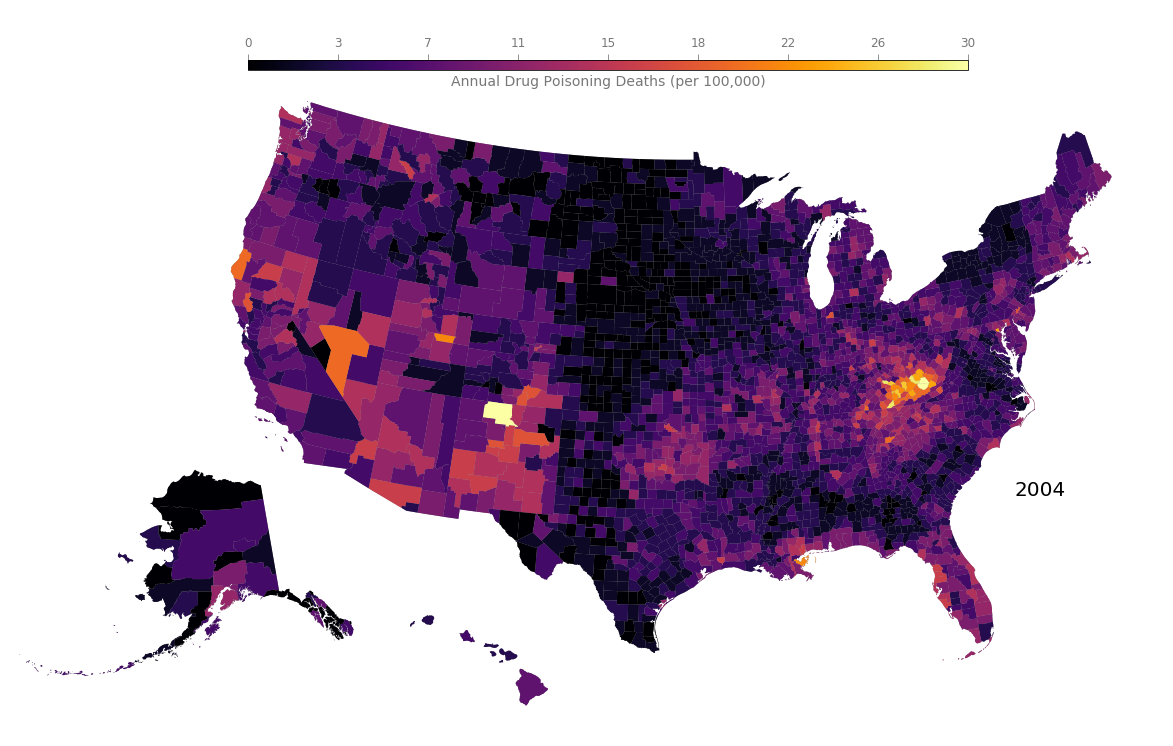

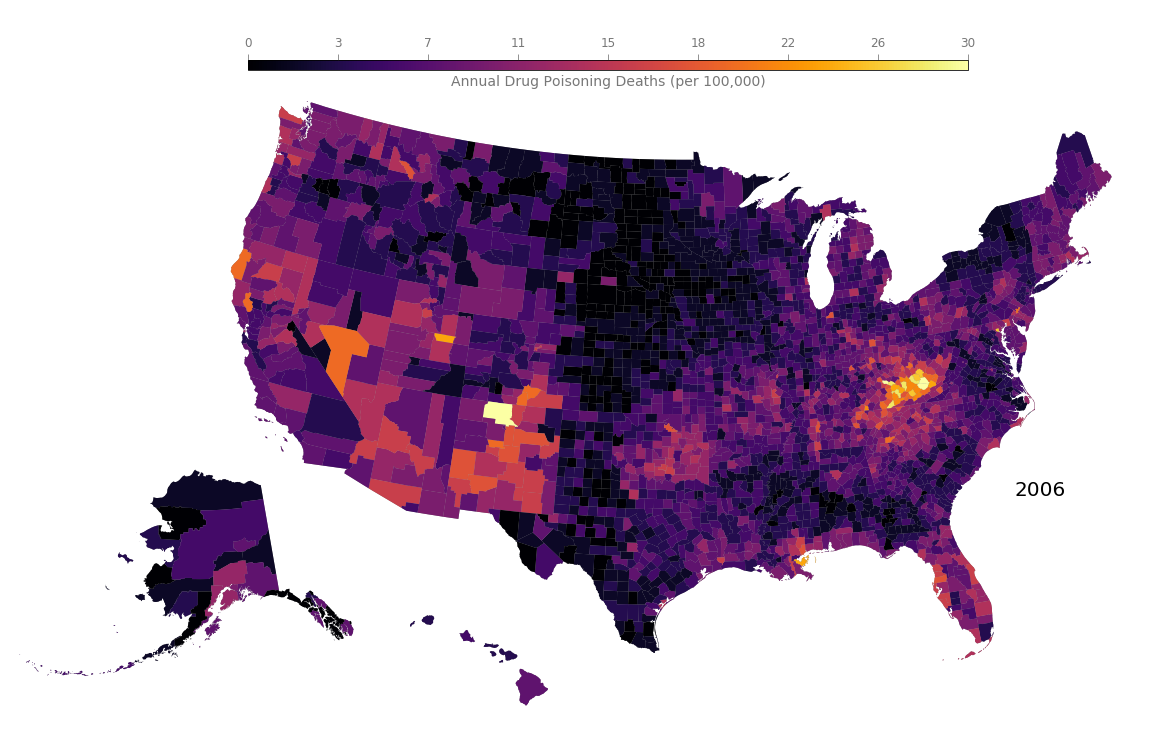

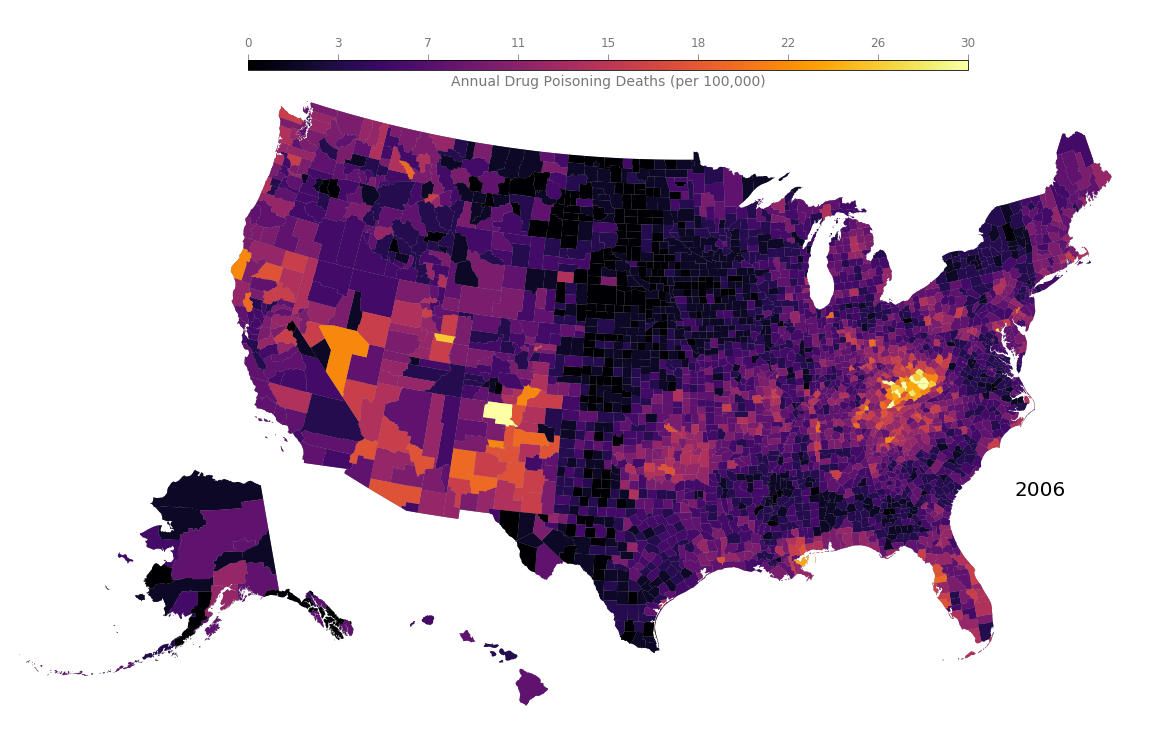

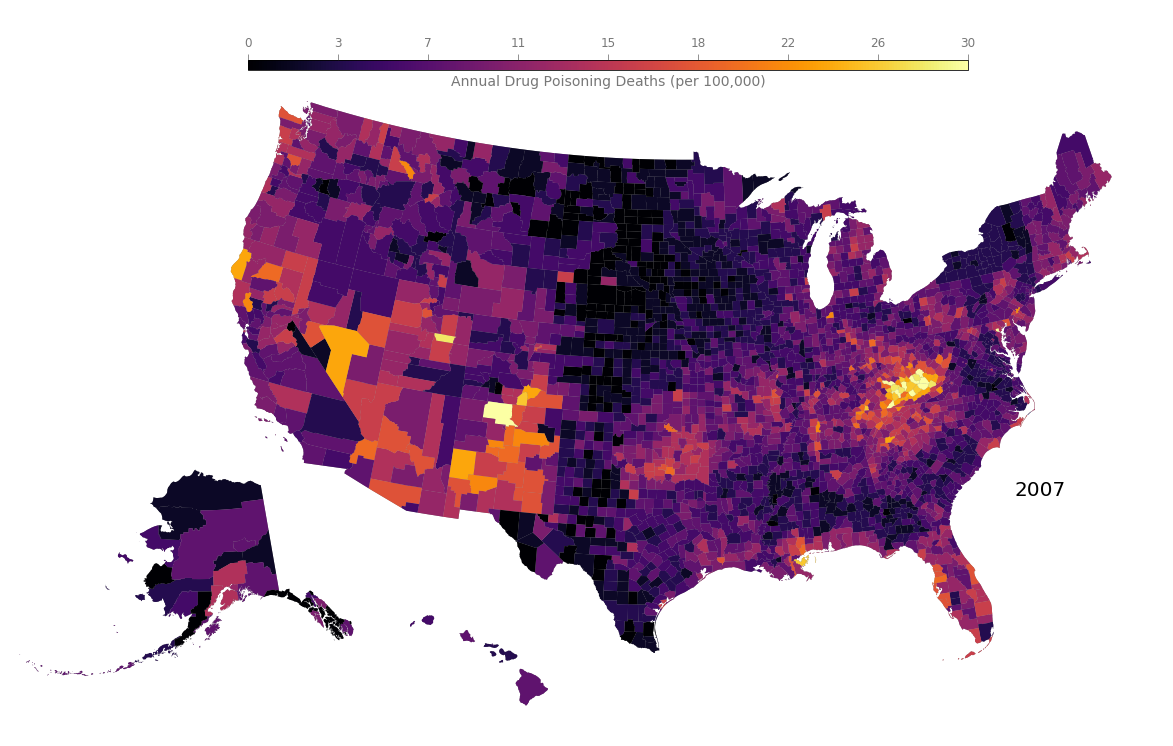

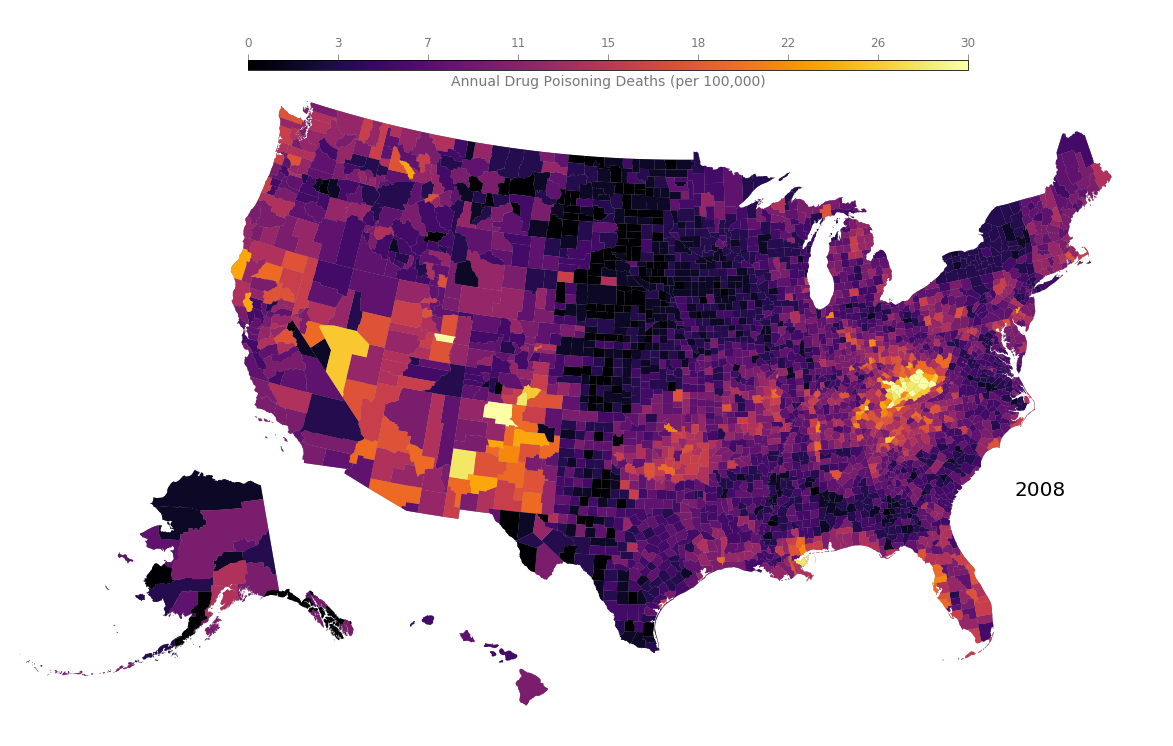

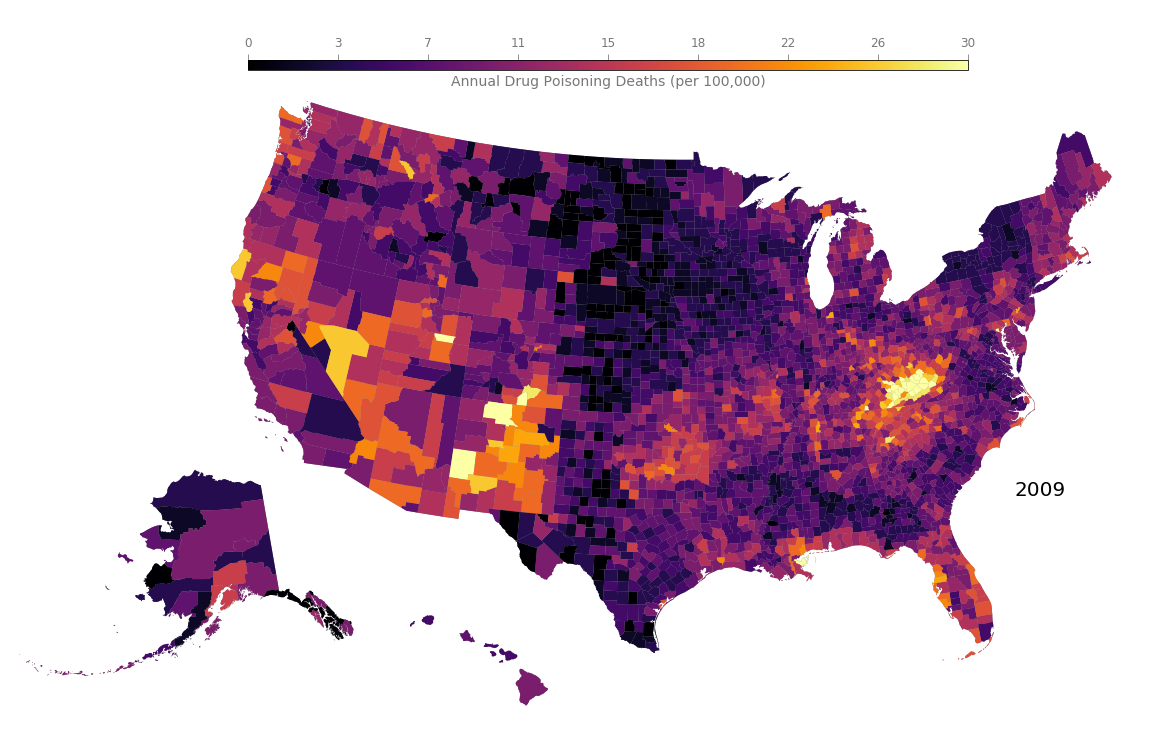

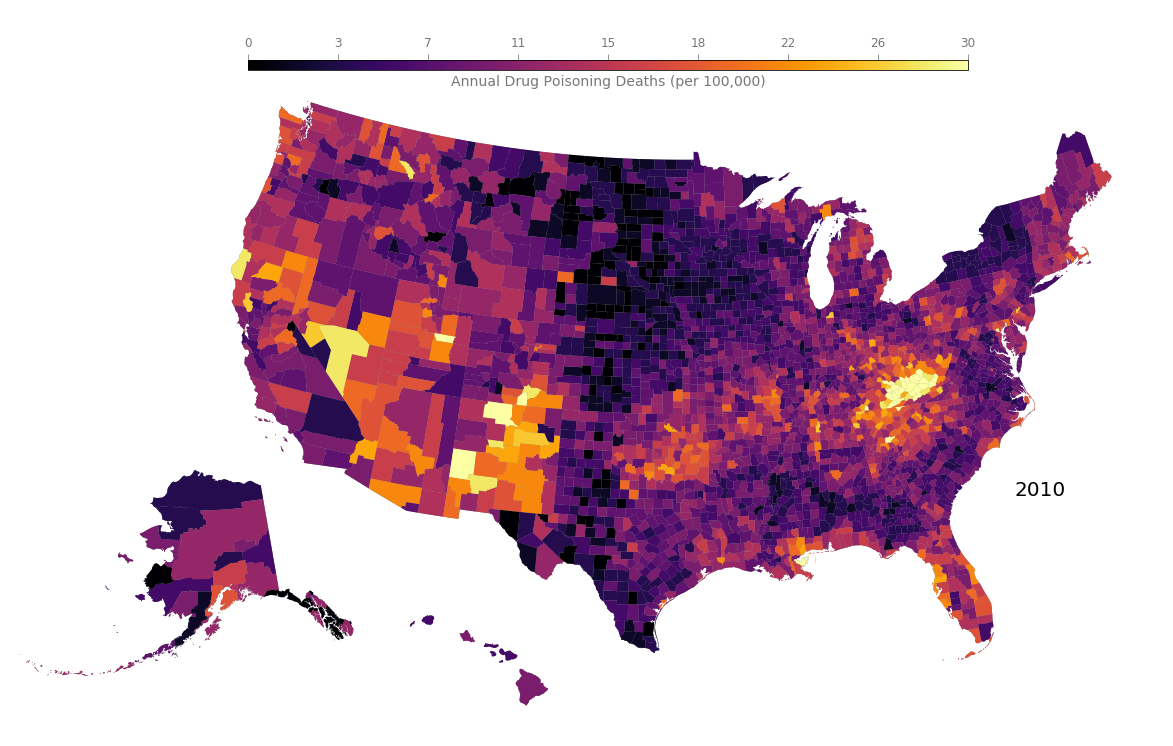

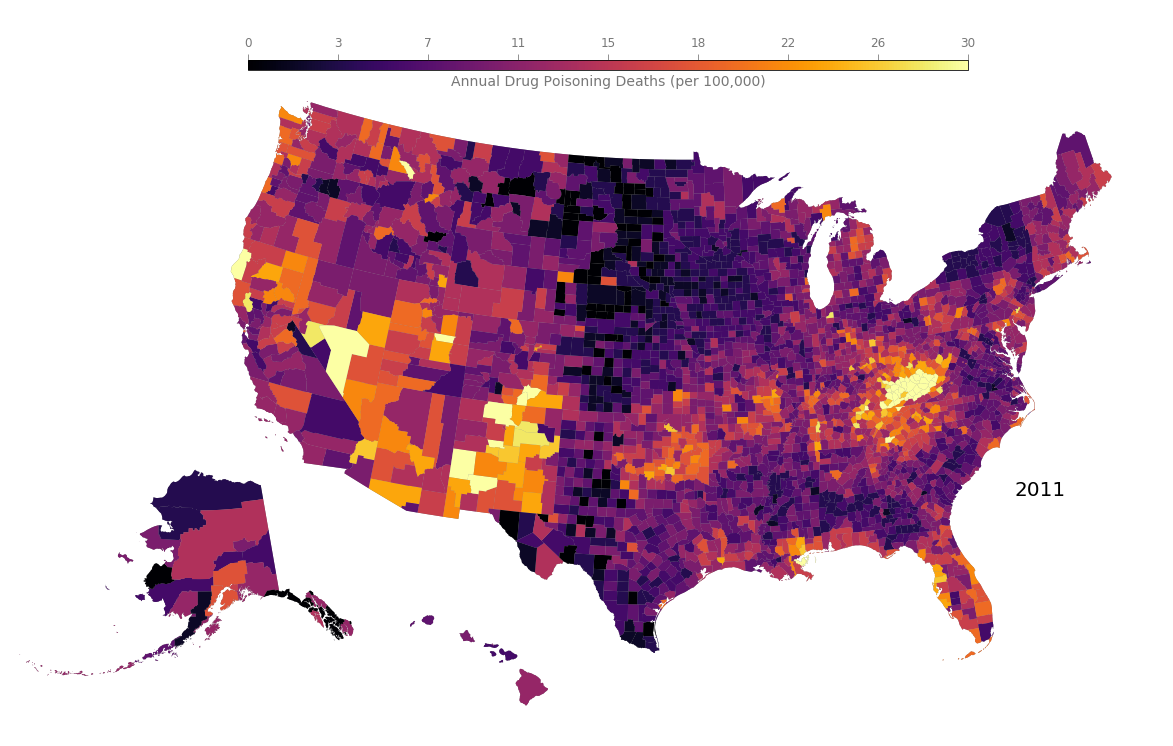

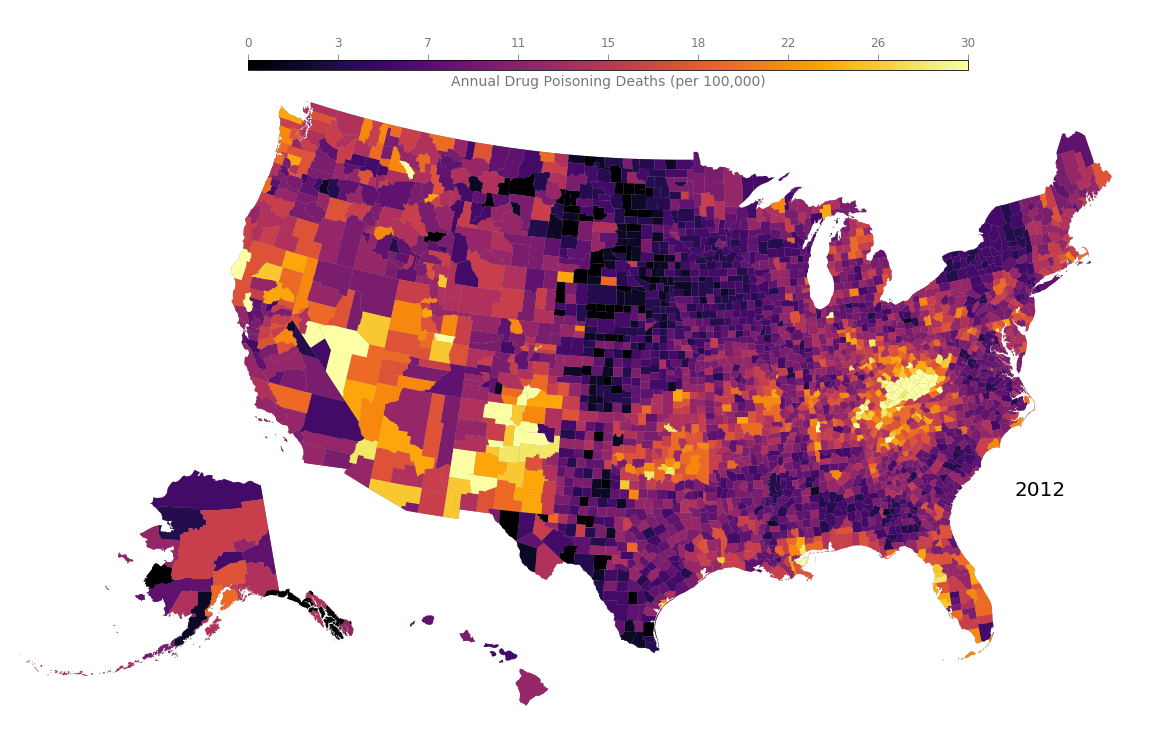

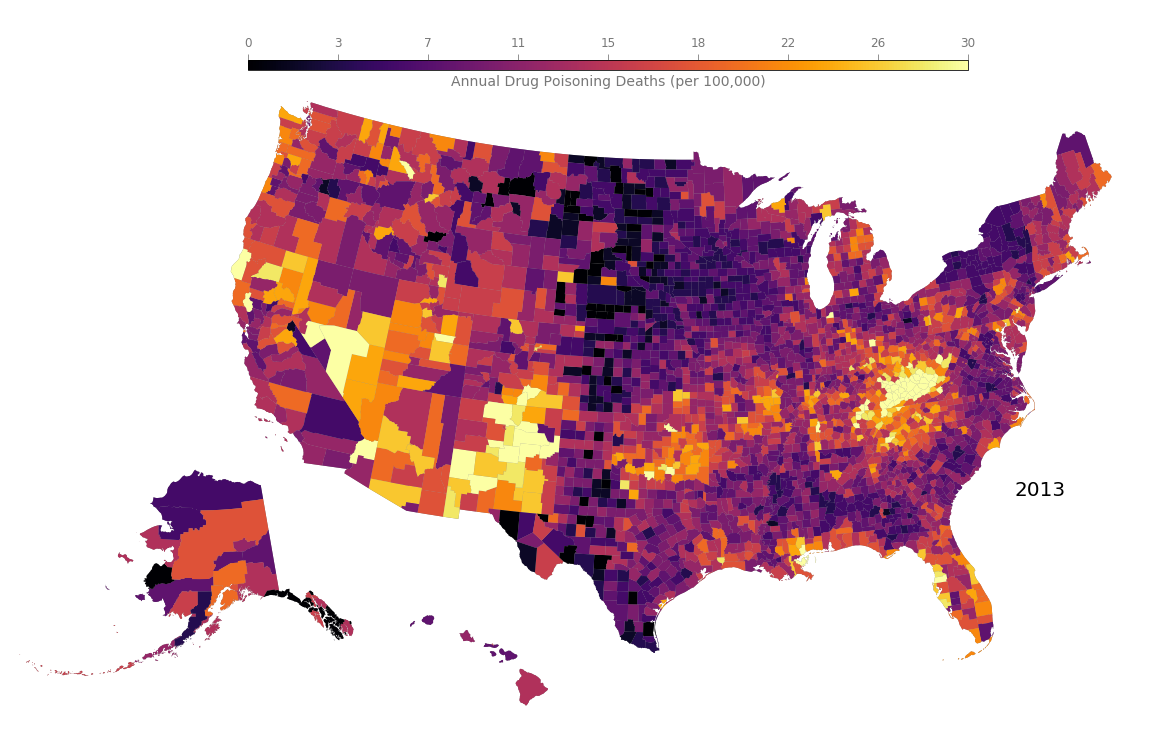

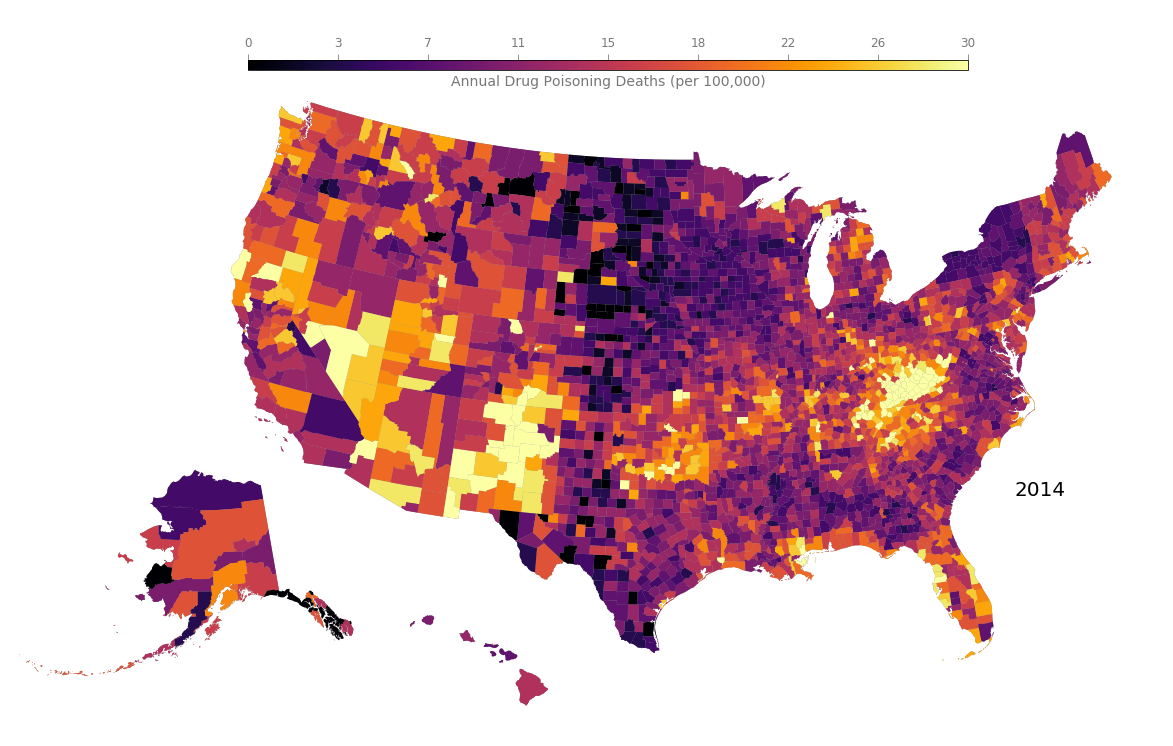

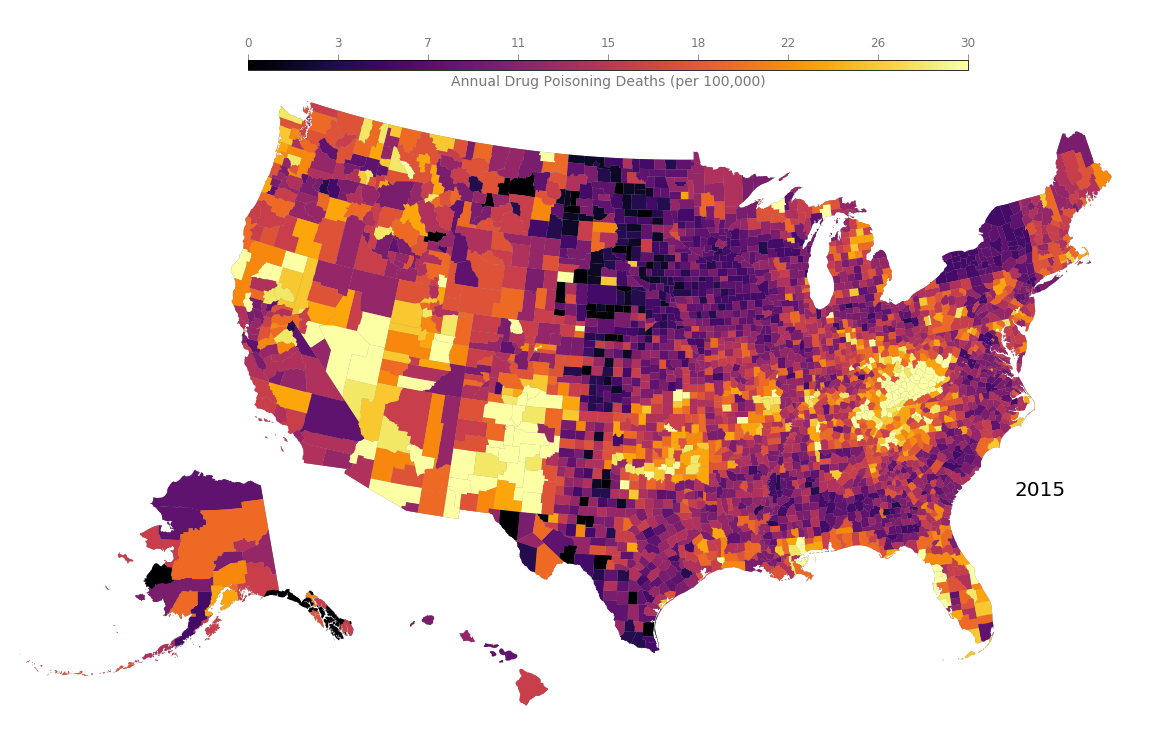

In [95]:
countyPlot(usa, 'Drug Poisoning, 1999', vmin=0.0, vmax=30.0, cmap = 'inferno', cLabel='Annual Drug Poisoning Deaths (per 100,000)',extraTitle='1999', saveFigure='plots/drugPoisonings/drugPoisoning1999.pdf')
countyPlot(usa, 'Drug Poisoning, 2000', vmin=0.0, vmax=30.0, cmap = 'inferno', cLabel='Annual Drug Poisoning Deaths (per 100,000)',extraTitle='2000', saveFigure='plots/drugPoisonings/drugPoisoning2000.pdf')
countyPlot(usa, 'Drug Poisoning, 2001', vmin=0.0, vmax=30.0, cmap = 'inferno', cLabel='Annual Drug Poisoning Deaths (per 100,000)',extraTitle='2001', saveFigure='plots/drugPoisonings/drugPoisoning2001.pdf')
countyPlot(usa, 'Drug Poisoning, 2002', vmin=0.0, vmax=30.0, cmap = 'inferno', cLabel='Annual Drug Poisoning Deaths (per 100,000)',extraTitle='2002', saveFigure='plots/drugPoisonings/drugPoisoning2002.pdf')
countyPlot(usa, 'Drug Poisoning, 2003', vmin=0.0, vmax=30.0, cmap = 'inferno', cLabel='Annual Drug Poisoning Deaths (per 100,000)',extraTitle='2003', saveFigure='plots/drugPoisonings/drugPoisoning2003.pdf')
countyPlot(usa, 'Drug Poisoning, 2004', vmin=0.0, vmax=30.0, cmap = 'inferno', cLabel='Annual Drug Poisoning Deaths (per 100,000)',extraTitle='2004', saveFigure='plots/drugPoisonings/drugPoisoning2004.pdf')
countyPlot(usa, 'Drug Poisoning, 2005', vmin=0.0, vmax=30.0, cmap = 'inferno', cLabel='Annual Drug Poisoning Deaths (per 100,000)',extraTitle='2006', saveFigure='plots/drugPoisonings/drugPoisoning2005.pdf')
countyPlot(usa, 'Drug Poisoning, 2006', vmin=0.0, vmax=30.0, cmap = 'inferno', cLabel='Annual Drug Poisoning Deaths (per 100,000)',extraTitle='2006', saveFigure='plots/drugPoisonings/drugPoisoning2006.pdf')
countyPlot(usa, 'Drug Poisoning, 2007', vmin=0.0, vmax=30.0, cmap = 'inferno', cLabel='Annual Drug Poisoning Deaths (per 100,000)',extraTitle='2007', saveFigure='plots/drugPoisonings/drugPoisoning2007.pdf')
countyPlot(usa, 'Drug Poisoning, 2008', vmin=0.0, vmax=30.0, cmap = 'inferno', cLabel='Annual Drug Poisoning Deaths (per 100,000)',extraTitle='2008', saveFigure='plots/drugPoisonings/drugPoisoning2008.pdf')
countyPlot(usa, 'Drug Poisoning, 2009', vmin=0.0, vmax=30.0, cmap = 'inferno', cLabel='Annual Drug Poisoning Deaths (per 100,000)',extraTitle='2009', saveFigure='plots/drugPoisonings/drugPoisoning2009.pdf')
countyPlot(usa, 'Drug Poisoning, 2010', vmin=0.0, vmax=30.0, cmap = 'inferno', cLabel='Annual Drug Poisoning Deaths (per 100,000)',extraTitle='2010', saveFigure='plots/drugPoisonings/drugPoisoning2010.pdf')
countyPlot(usa, 'Drug Poisoning, 2011', vmin=0.0, vmax=30.0, cmap = 'inferno', cLabel='Annual Drug Poisoning Deaths (per 100,000)',extraTitle='2011', saveFigure='plots/drugPoisonings/drugPoisoning2011.pdf')
countyPlot(usa, 'Drug Poisoning, 2012', vmin=0.0, vmax=30.0, cmap = 'inferno', cLabel='Annual Drug Poisoning Deaths (per 100,000)',extraTitle='2012', saveFigure='plots/drugPoisonings/drugPoisoning2012.pdf')
countyPlot(usa, 'Drug Poisoning, 2013', vmin=0.0, vmax=30.0, cmap = 'inferno', cLabel='Annual Drug Poisoning Deaths (per 100,000)',extraTitle='2013', saveFigure='plots/drugPoisonings/drugPoisoning2013.pdf')
countyPlot(usa, 'Drug Poisoning, 2014', vmin=0.0, vmax=30.0, cmap = 'inferno', cLabel='Annual Drug Poisoning Deaths (per 100,000)',extraTitle='2014', saveFigure='plots/drugPoisonings/drugPoisoning2014.pdf')
countyPlot(usa, 'Drug Poisoning, 2015', vmin=0.0, vmax=30.0, cmap = 'inferno', cLabel='Annual Drug Poisoning Deaths (per 100,000)',extraTitle='2015', saveFigure='plots/drugPoisonings/drugPoisoning2015.pdf')

In [5]:
#Class to translate Pandas DataFrames into Numpy Arrays
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

class Analysis():
    """
    A class to do machine learning on a GeoPandas DataFrame. Trains using the features, and learns on the labels
    """
    def __init__(self, data, features, labels, regressionType = 'Linear', numDivisions = 50):
        self.data = data
        self.features = features
        self.labels = labels
        self.regressionType = regressionType
        self.numDivisions = numDivisions
        self.results = pd.Series()
        self.stateCodes={'AL':'01','AZ':'04','AR':'05','CA':'06','CO':'08','CT':'09','DE':'10','FL':'12','GA':'13','HI':'15','ID':'16','IL':'17','IN':'18','IA':'19','KS':'20','KY':'21','LA':'22','ME':'23','MD':'24','MA':'25','MI':'26','MN':'27','MS':'28','MO':'29','MT':'30','NE':'31','NV':'32','NH':'33','NJ':'34','NM':'35','NY':'36','NC':'37','ND':'38','OH':'39','OK':'40','OR':'41','PA':'42','RI':'44','SC':'45','SD':'46','TN':'47','TX':'48','UT':'49','VT':'50','VA':'51','WA':'53','WV':'54','WI':'55','WY':'56'}
        self.acres_to_m2 = 4047.

        if regressionType == 'Linear':
            self.regressor = ElasticNet(alpha=0.001, l1_ratio=0.1)
        elif regressionType == 'MLP':
            self.regressor = MLPRegressor(hidden_layer_sizes=[100, 100, 100],max_iter=25000, early_stopping=True, alpha=0.2)
        elif regressionType == 'RandomForest':
            self.regressor = RandomForestRegressor(max_features=30, n_estimators=200)

    def splitTestTrain(self, technique='hash', i=0, hash=hashlib.md5):
        """
        Split data by an index i
        If technique == 'hash' (default & recommended for a national analysis), compute the hash of the FIPS code and check whether it is between i/numDivisions and (i+1)/numDivisions
        If technique == 'statewise' (if you want to split training & test by state), the state(s) abbreviation as the test data. Here i is a list of abbreviations
        If technique == 'individual' (split each county separately as its own test set)
        """
        if technique=='hash':
            if self.numDivisions>1:
                hashes = list(map(float,map((lambda id_: int(hash(str(id_).encode('utf-8')).hexdigest(), 16)%256), self.data.index.map(int))))
                hashes = [value/256.0 for value in hashes]

                testSet = list(map((lambda theHash: theHash>=float(i)/self.numDivisions and theHash<float(i+1.0)/self.numDivisions), hashes))
                trainingSet = [not bool for bool in testSet]
                #Return training data, test data
                self.trainingData = self.data.loc[trainingSet]
                self.testData = self.data.loc[testSet]
            else:
                self.trainingData = self.data

        if technique=='statewise':
            testIndices = np.array([],'i')
            for state in i:
                testIndices= np.concatenate([testIndices,np.where((self.data.index>int(self.stateCodes[state])*1000) & (self.data.index<(int(self.stateCodes[state])+1)*1000))[0]])
            self.testData = self.data.iloc[testIndices]

            trainingIndices = range(len(self.data))
            for k in testIndices:
                trainingIndices.remove(k)
            self.trainingData = self.data.iloc[trainingIndices]

        if technique =='individual':
            self.testData = pd.DataFrame(self.data.iloc[i]).transpose()
            self.trainingData = self.data.iloc[[i != k for k in range(len(self.data.index))]]


    def makePipeline(self, demographicsChanges=True, economicChanges=True):
        """
        Make a scikit-learn pipeline to do standard data processing tasks like:
        - Normalize the data to be between 0 and 1
        - Add combined attributes (i.e. changes to data over time)
        - Select which attributes to look at
        """
        self.dataPipeline = Pipeline([
            ('selector', DataFrameSelector(self.features)),
            ])#StandardScaler()),])
        self.dataScaler = Pipeline([('std_scaler', MinMaxScaler()),])

    def prepData(self):
        """
        Define the features & labels of the training and test sets
        Then transform the data via the pipeline
        After this is run, the data should be ready for training
        """
        self.trainingFeatures = self.trainingData.drop(self.labels, axis=1)
        numRepeats = np.log10(self.data['Estimate; SEX AND AGE - Total population'][self.trainingFeatures.index]).astype(int)
        self.trainingLabels = self.trainingData[self.labels].copy().values
        self.trainingFeatures = self.dataPipeline.fit_transform(self.trainingFeatures)
        self.trainingFeatures = self.dataScaler.fit_transform(self.trainingFeatures)

        performRepeats = True
        if performRepeats:
            #Repeat each county in the training set by the log10 of its population.
            self.trainingFeatures = np.repeat(self.trainingFeatures, numRepeats, axis=0).reshape(np.sum(numRepeats),len(self.features))
            self.trainingLabels = np.repeat(self.trainingLabels, numRepeats, axis=0).reshape(np.sum(numRepeats),1)

        if self.labels in self.testData.columns:
            self.testFeatures = self.testData.drop(self.labels, axis=1)
            self.testLabels = self.testData[self.labels].copy()
            self.testFeatures = self.dataPipeline.transform(self.testFeatures)
            self.testFeatures = self.dataScaler.transform(self.testFeatures)

        else:
            self.testFeatures = self.dataPipeline.transform(self.testData)
            self.testFeatures = self.dataScaler.transform(self.testData)


    def trainModel(self):
        """
        Train the regressor on self.trainingData with self.trainingLabels
        """
        self.regressor.fit(self.trainingFeatures, self.trainingLabels.ravel())

    def predictModel(self):
        """
        Use the trained regressor to predict the labels of the self.testData
        """
        self.predictions = self.regressor.predict(self.testFeatures)
        return self.predictions

    def residModel(self):
        """
        Calculate the difference between the prediction and the data
        """
        self.residuals = self.testLabels-self.predictions
        return self.residuals

    def concatenateResiduals(self):
        """
        """
        self.results = pd.concat([self.results, self.residuals])

    def rmsModel(self):
        """
        Get the RMS of the residuals
        """
        self.rms = np.sqrt(np.mean(self.residuals.values**2))
        return self.rms


In [6]:
#Combined attributes
usa['GOPChange'] = usa['per_gop_2016']-usa['per_gop_2012']
usa['PopDensity'] = usa['Estimate; SEX AND AGE - Total population'].values/usa['ALAND'].values
usa['AllCrops'] = usa['Soybeans']+usa['Corn']+usa['Cotton']+usa['WinterWheat']
usa['turnout2016'] = usa['total_votes_2016']/(0.01*usa['Percent; SEX AND AGE - 18 years and over']*usa['Estimate; SEX AND AGE - Total population'])
usa['turnout2012'] = usa['total_votes_2012']/(0.01*usa['Percent; SEX AND AGE - 18 years and over']*usa['Estimate; SEX AND AGE - Total population'])
usa['turnoutChange'] = usa['turnout2016']-usa['turnout2012']

In [7]:
#Start with the variable most correlated with GOPChange
features = ['Percent; EDUCATIONAL ATTAINMENT - Population 25 years and over - High school graduate (includes equivalency)']
labels= 'GOPChange'

#Add features based on which ones explain the most residuals
for k in range(30):

    #for feature in features:
    #    if np.max(usa[feature].values)>1.0:
    #        usa[feature] = usa[feature].apply(divideBy100)
    #    if np.std(usa[feature].values**2)>np.std(usa[feature].values):
    #        usa[feature].apply(squareVal)
    #    if np.std(np.sqrt(usa[feature].values))>np.std(usa[feature].values):
    #        usa[feature].apply(sqrtVal)

    analysis = Analysis(usa, features, labels, regressionType='MLP')
    analysis.makePipeline()

    for i in range(50):
        analysis.splitTestTrain(i=i)
        analysis.prepData()
        analysis.trainModel()
        analysis.predictModel()
        analysis.residModel()
        analysis.concatenateResiduals()
    usa['Residuals'] = analysis.results
    correlations = usa.corr()['Residuals'].sort_values()
    for feature in correlations.index:
        if pd.isna(correlations[feature]) or 'Margin of Error' in feature or 'Estimate; ANCESTRY' in feature or feature in features or feature == labels or feature in ['combined_fips', 'votes_dem_2016', 'votes_gop_2016', 'total_votes_2016','per_dem_2016', 'per_gop_2016', 'diff_2016', 'per_point_diff_2016']:
            correlations = correlations.drop(feature)
    print('New best feature: ' + str(correlations.index[np.nanargmax(np.abs(correlations.values[correlations.values<1.0]))]))
    print('Correlation value: ' + str(correlations[np.nanargmax(np.abs(correlations.values[correlations.values<1.0]))]))
    
    features.append(correlations.index[np.nanargmax(np.abs(correlations.values[correlations.values<1.0]))])
    
print('Std deviation: ' + str(100.*np.std(analysis.results.values))+'%')
results = gp.GeoDataFrame(analysis.results, columns=['Residuals']).merge(countyShapes, left_index=True, right_index=True)

New best feature: Percent; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - White alone
Correlation value: 0.4776218098061626
New best feature: Percent; EDUCATIONAL ATTAINMENT - Population 25 years and over - Associate's degree
Correlation value: 0.3226142384737064
New best feature: Percent; EDUCATIONAL ATTAINMENT - Percent bachelor's degree or higher
Correlation value: -0.3067372757257103
New best feature: per_dem_2012
Correlation value: 0.3197012820455305
New best feature: Percent; INDUSTRY - Civilian employed population 16 years and over - Professional, scientific, and management, and administrative and waste management services
Correlation value: -0.261525108959582
New best feature: Percent; ANCESTRY - Total population - Norwegian
Correlation value: 0.22756965518642572
New best feature: Percent; RACE - Race alone or in combination with one or more other races - Total population - Black or African American
Correlation value: -0.22032193166145167
New best fea

/home/christian/Packages/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 

In [ ]:
countyPlot(results, 'Residuals',cmap='coolwarm',cLabel='Turnout Residual', vmin=-0.1, vmax=0.1)